# ??? IoT IDS - Day 1: EDA
## 1. Load the Stratified Sample Data
We loaded a 10% stratified sample from 10 files to keep memory low (~2.3M rows).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

# Load the sample we created earlier
df = pd.read_parquet('processed/eda_sample.parquet')
print(f'Dataset Shape: {df.shape}')
df.head()

Dataset Shape: (236700, 47)


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,0.00,1.00,64.00,47.073062,47.073062,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.312441e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
1,0.002530,75.15,6.00,63.68,30.424015,30.424015,0.0,0.0,0.0,0.0,...,13.519695,68.68,8.306743e+07,9.5,10.640127,19.230845,4401.071911,0.15,141.55,DDoS-TCP_Flood
2,0.549882,152.82,6.00,64.00,5.130662,5.130662,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.336247e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-SynonymousIP_Flood
3,3.882693,109.52,6.11,66.49,0.704533,0.704533,0.0,0.0,1.0,0.0,...,1.588514,54.55,8.298555e+07,9.5,10.438598,2.250317,21.025303,0.13,141.55,DoS-SYN_Flood
4,0.000000,0.00,1.00,64.00,5.830646,5.830646,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.315026e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood


## 2. Check Missing Values & Data Types

In [2]:
missing_values = df.isnull().sum()
print('Missing Values:\n', missing_values[missing_values > 0])

# Check for Infinite values
inf_counts = np.isinf(df.select_dtypes(include=np.number)).sum()
print('\nInfinite Values:\n', inf_counts[inf_counts > 0])

print('\nData Types:\n', df.dtypes.value_counts())

Missing Values:
 Series([], dtype: int64)

Infinite Values:
 Series([], dtype: int64)

Data Types:
 float64    46
str         1
Name: count, dtype: int64


## 3. Analyze the 34-Class Distribution (Extreme Imbalance)

C:\Users\digilians01\AppData\Local\Temp\ipykernel_7568\1580929361.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=class_counts.index, x=class_counts.values, palette='viridis')


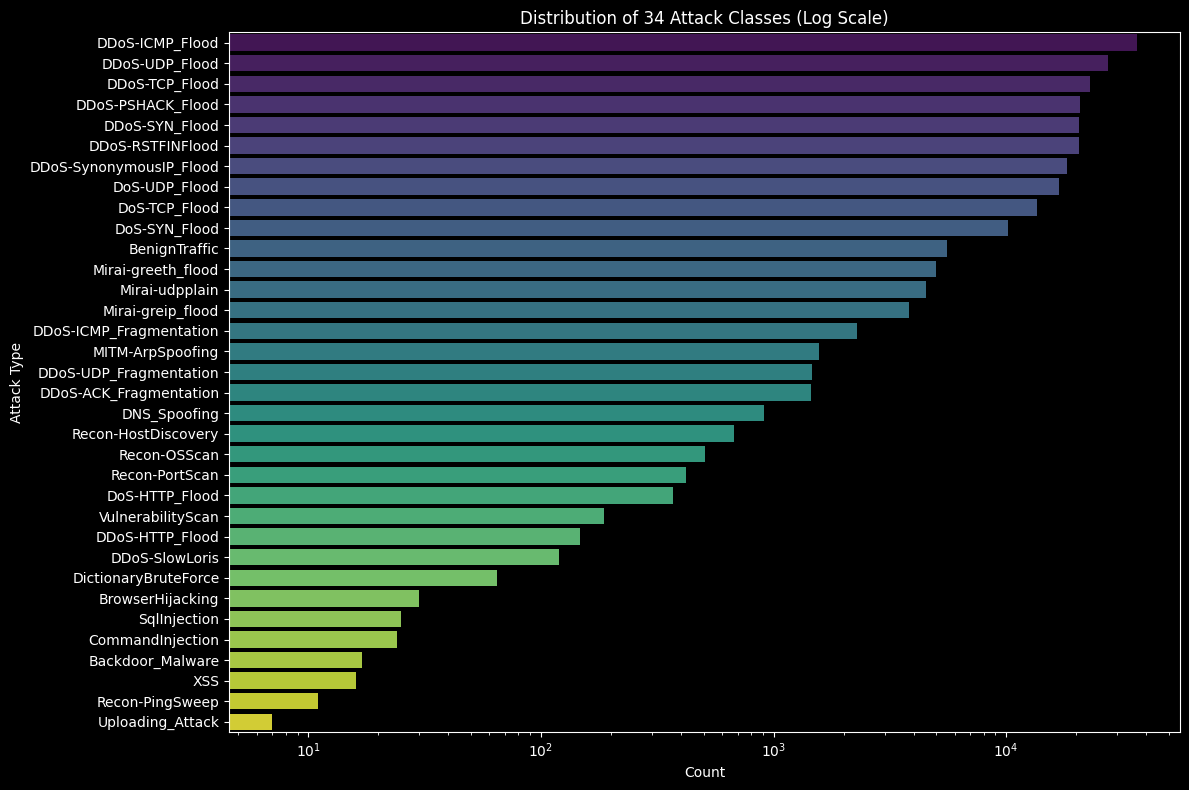

label
DDoS-ICMP_Flood            36456
DDoS-UDP_Flood             27443
DDoS-TCP_Flood             22888
DDoS-PSHACK_Flood          20798
DDoS-SYN_Flood             20615
DDoS-RSTFINFlood           20489
DDoS-SynonymousIP_Flood    18210
DoS-UDP_Flood              16875
DoS-TCP_Flood              13520
DoS-SYN_Flood              10204
BenignTraffic               5588
Mirai-greeth_flood          4984
Mirai-udpplain              4522
Mirai-greip_flood           3817
DDoS-ICMP_Fragmentation     2289
MITM-ArpSpoofing            1561
DDoS-UDP_Fragmentation      1459
DDoS-ACK_Fragmentation      1449
DNS_Spoofing                 914
Recon-HostDiscovery          677
Recon-OSScan                 505
Recon-PortScan               419
DoS-HTTP_Flood               370
VulnerabilityScan            186
DDoS-HTTP_Flood              147
DDoS-SlowLoris               120
DictionaryBruteForce          65
BrowserHijacking              30
SqlInjection                  25
CommandInjection              24
Back

In [3]:
plt.figure(figsize=(12, 8))
class_counts = df['label'].value_counts()
sns.barplot(y=class_counts.index, x=class_counts.values, palette='viridis')
plt.title('Distribution of 34 Attack Classes (Log Scale)')
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.xscale('log')  # Log scale because of extreme imbalance
plt.tight_layout()
plt.savefig('figures/34_class_distribution.png', dpi=300)
plt.show()

print(class_counts)

## 4. Map to 8-Class Family Taxonomy and Visualize

C:\Users\digilians01\AppData\Local\Temp\ipykernel_7568\2775322326.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=family_counts.index, y=family_counts.values, palette='rocket')


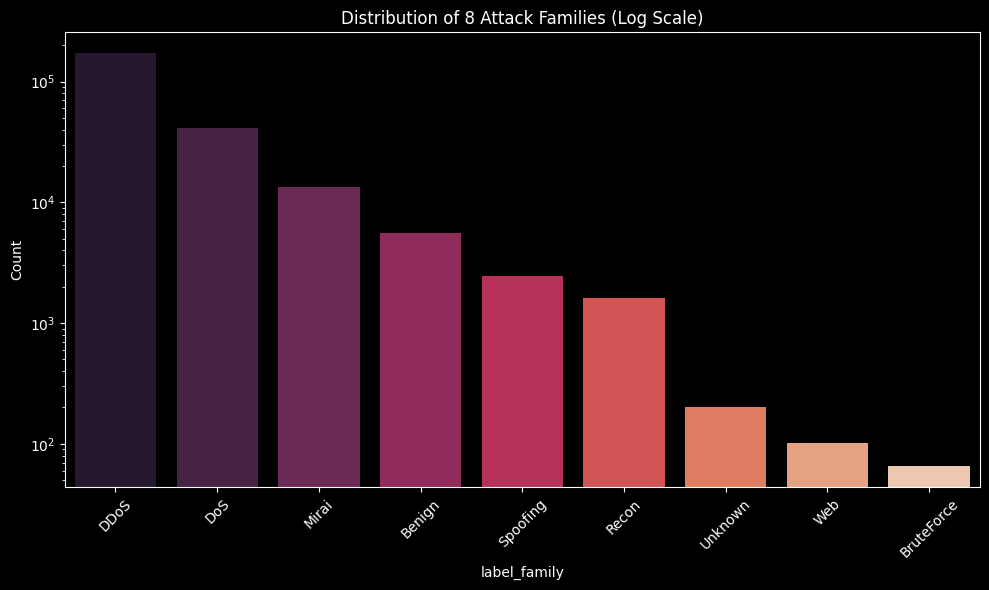

label_family
DDoS          172363
DoS            40969
Mirai          13323
Benign          5588
Spoofing        2475
Recon           1612
Unknown          203
Web              102
BruteForce        65
Name: count, dtype: int64


In [4]:
def map_to_family(label):
    if label == 'BenignTraffic': return 'Benign'
    elif label.startswith('DDoS'): return 'DDoS'
    elif label.startswith('DoS'): return 'DoS'
    elif label.startswith('Mirai'): return 'Mirai'
    elif label.startswith('Recon'): return 'Recon'
    elif label in ['DNS_Spoofing', 'MITM-ArpSpoofing']: return 'Spoofing'
    elif label in ['BrowserHijacking', 'CommandInjection', 'SqlInjection', 'Uploading_Attack', 'XSS']: return 'Web'
    elif label == 'DictionaryBruteForce': return 'BruteForce'
    return 'Unknown'

df['label_family'] = df['label'].apply(map_to_family)

plt.figure(figsize=(10, 6))
family_counts = df['label_family'].value_counts()
sns.barplot(x=family_counts.index, y=family_counts.values, palette='rocket')
plt.title('Distribution of 8 Attack Families (Log Scale)')
plt.ylabel('Count')
plt.yscale('log')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/8_class_distribution.png', dpi=300)
plt.show()

print(family_counts)

## 5. Analyze Feature Correlations

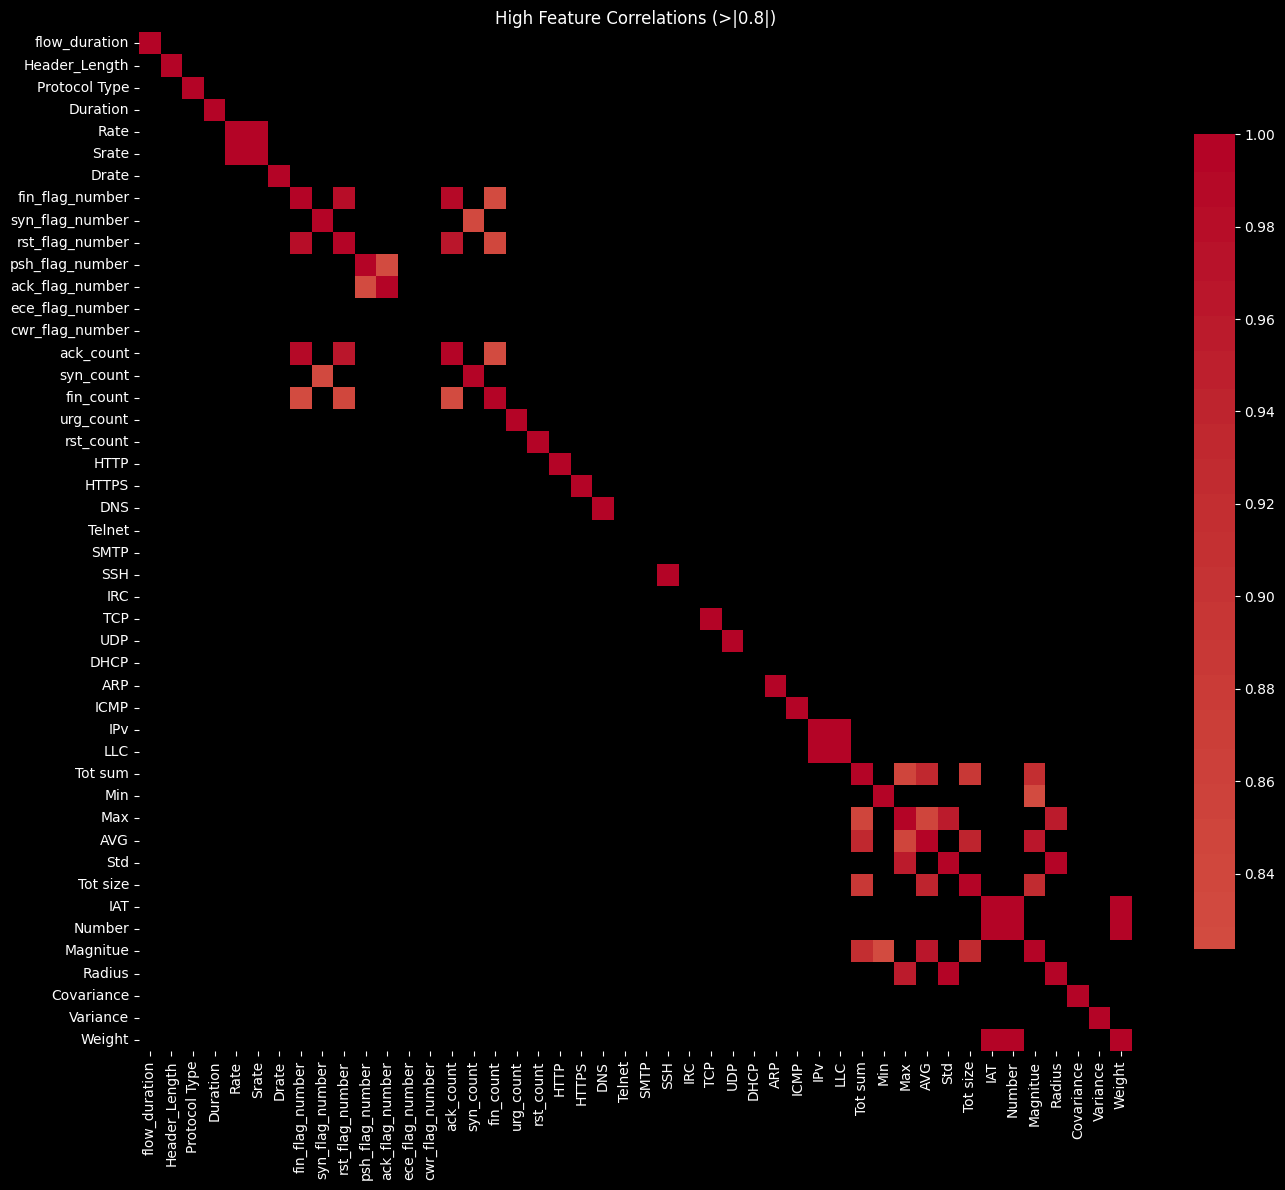

In [5]:
plt.figure(figsize=(14, 12))
# Compute correlation matrix for numeric features
numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()

# Show only correlations > 0.8 to identify redundant features
high_corr = corr[(corr >= 0.8) | (corr <= -0.8)]
sns.heatmap(high_corr, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.8})
plt.title('High Feature Correlations (>|0.8|)')
plt.tight_layout()
plt.savefig('figures/high_correlation_heatmap.png', dpi=300)
plt.show()